# 82 Octet Binary Dataset

In [1110]:
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [1111]:
def round_array_to_binary(arr, threshold=0.5):
    arr = np.array(arr)  # Convert input to NumPy array if it's not already
    return np.where(arr >= threshold, 1, 0)

In [1112]:
octet = pd.read_csv('octet.csv')
octet_selected = octet[['Delta E', 'rp(A)', 'rp(B)', 'rs(A)']]
# octet_selected['sigma'] = octet_selected['rp(A)']-octet_selected['rp(B)']
octet_sel = pd.DataFrame()
octet_sel.loc[:, 'sigma'] = octet_selected['rp(A)']-octet_selected['rp(B)']
octet_selected = pd.concat([octet_sel, octet_selected], axis=1)
# octet_selected = octet_selected.to_numpy()

In [1113]:
octet_selected.loc[(octet_selected['sigma']>=0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=-0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=1.16) & (octet_selected['sigma']>=-1.16) & (octet_selected['rs(A)'] <=1.27), 'RS_ZB'] = -1 
octet_selected.loc[octet_selected['RS_ZB'].isnull(), 'RS_ZB'] = 0

octet_selected.loc[(octet_selected['sigma']>=0.91), 'sigma>0.91'] = 1
octet_selected.loc[octet_selected['sigma>0.91'].isnull(), 'sigma>0.91'] = 0

octet_selected.loc[(octet_selected['sigma']<=-0.91), 'sigma<-0.91'] = 1 
octet_selected.loc[octet_selected['sigma<-0.91'].isnull(), 'sigma<-0.91'] = 0

octet_selected.loc[(octet_selected['rs(A)']>=1.22), 'rs>1.22'] = 1 
octet_selected.loc[octet_selected['rs>1.22'].isnull(), 'rs>1.22'] = 0

octet_selected.loc[(octet_selected['sigma']<=1.16), 'sigma<1.16'] = 1 
octet_selected.loc[octet_selected['sigma<1.16'].isnull(), 'sigma<1.16'] = 0

octet_selected.loc[(octet_selected['sigma']>=-1.16), 'sigma>-1.16'] = 1 
octet_selected.loc[octet_selected['sigma>-1.16'].isnull(), 'sigma>-1.16'] = 0

octet_selected.loc[(octet_selected['rs(A)']<=1.27), 'rs<1.27'] = 1 
octet_selected.loc[octet_selected['rs<1.27'].isnull(), 'rs<1.27'] = 0

# second_layer_data = octet_selected[['sigma>0.91', 'sigma<-0.91', 'sigma<1.16', 'sigma>-1.16', 'rs>1.22','rs<1.27', 'RS_ZB']]

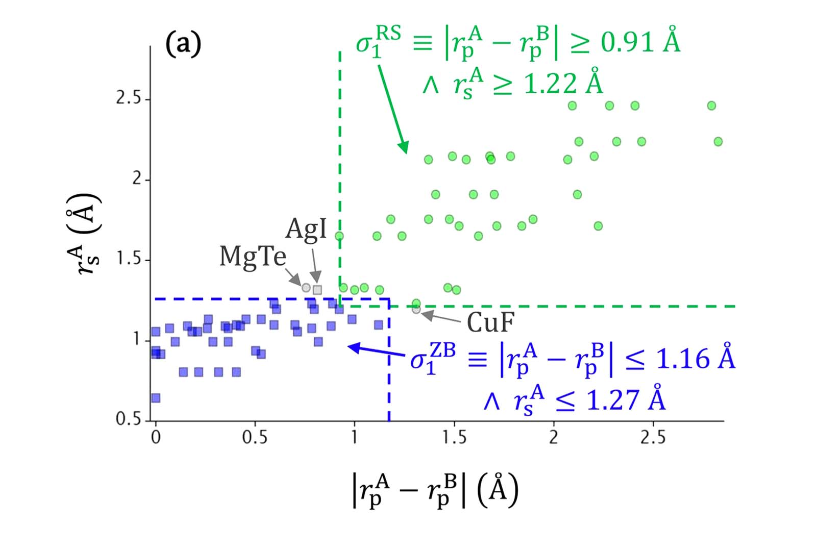

In [1114]:
from IPython import display
display.Image("OctetBinaryPlot.png")

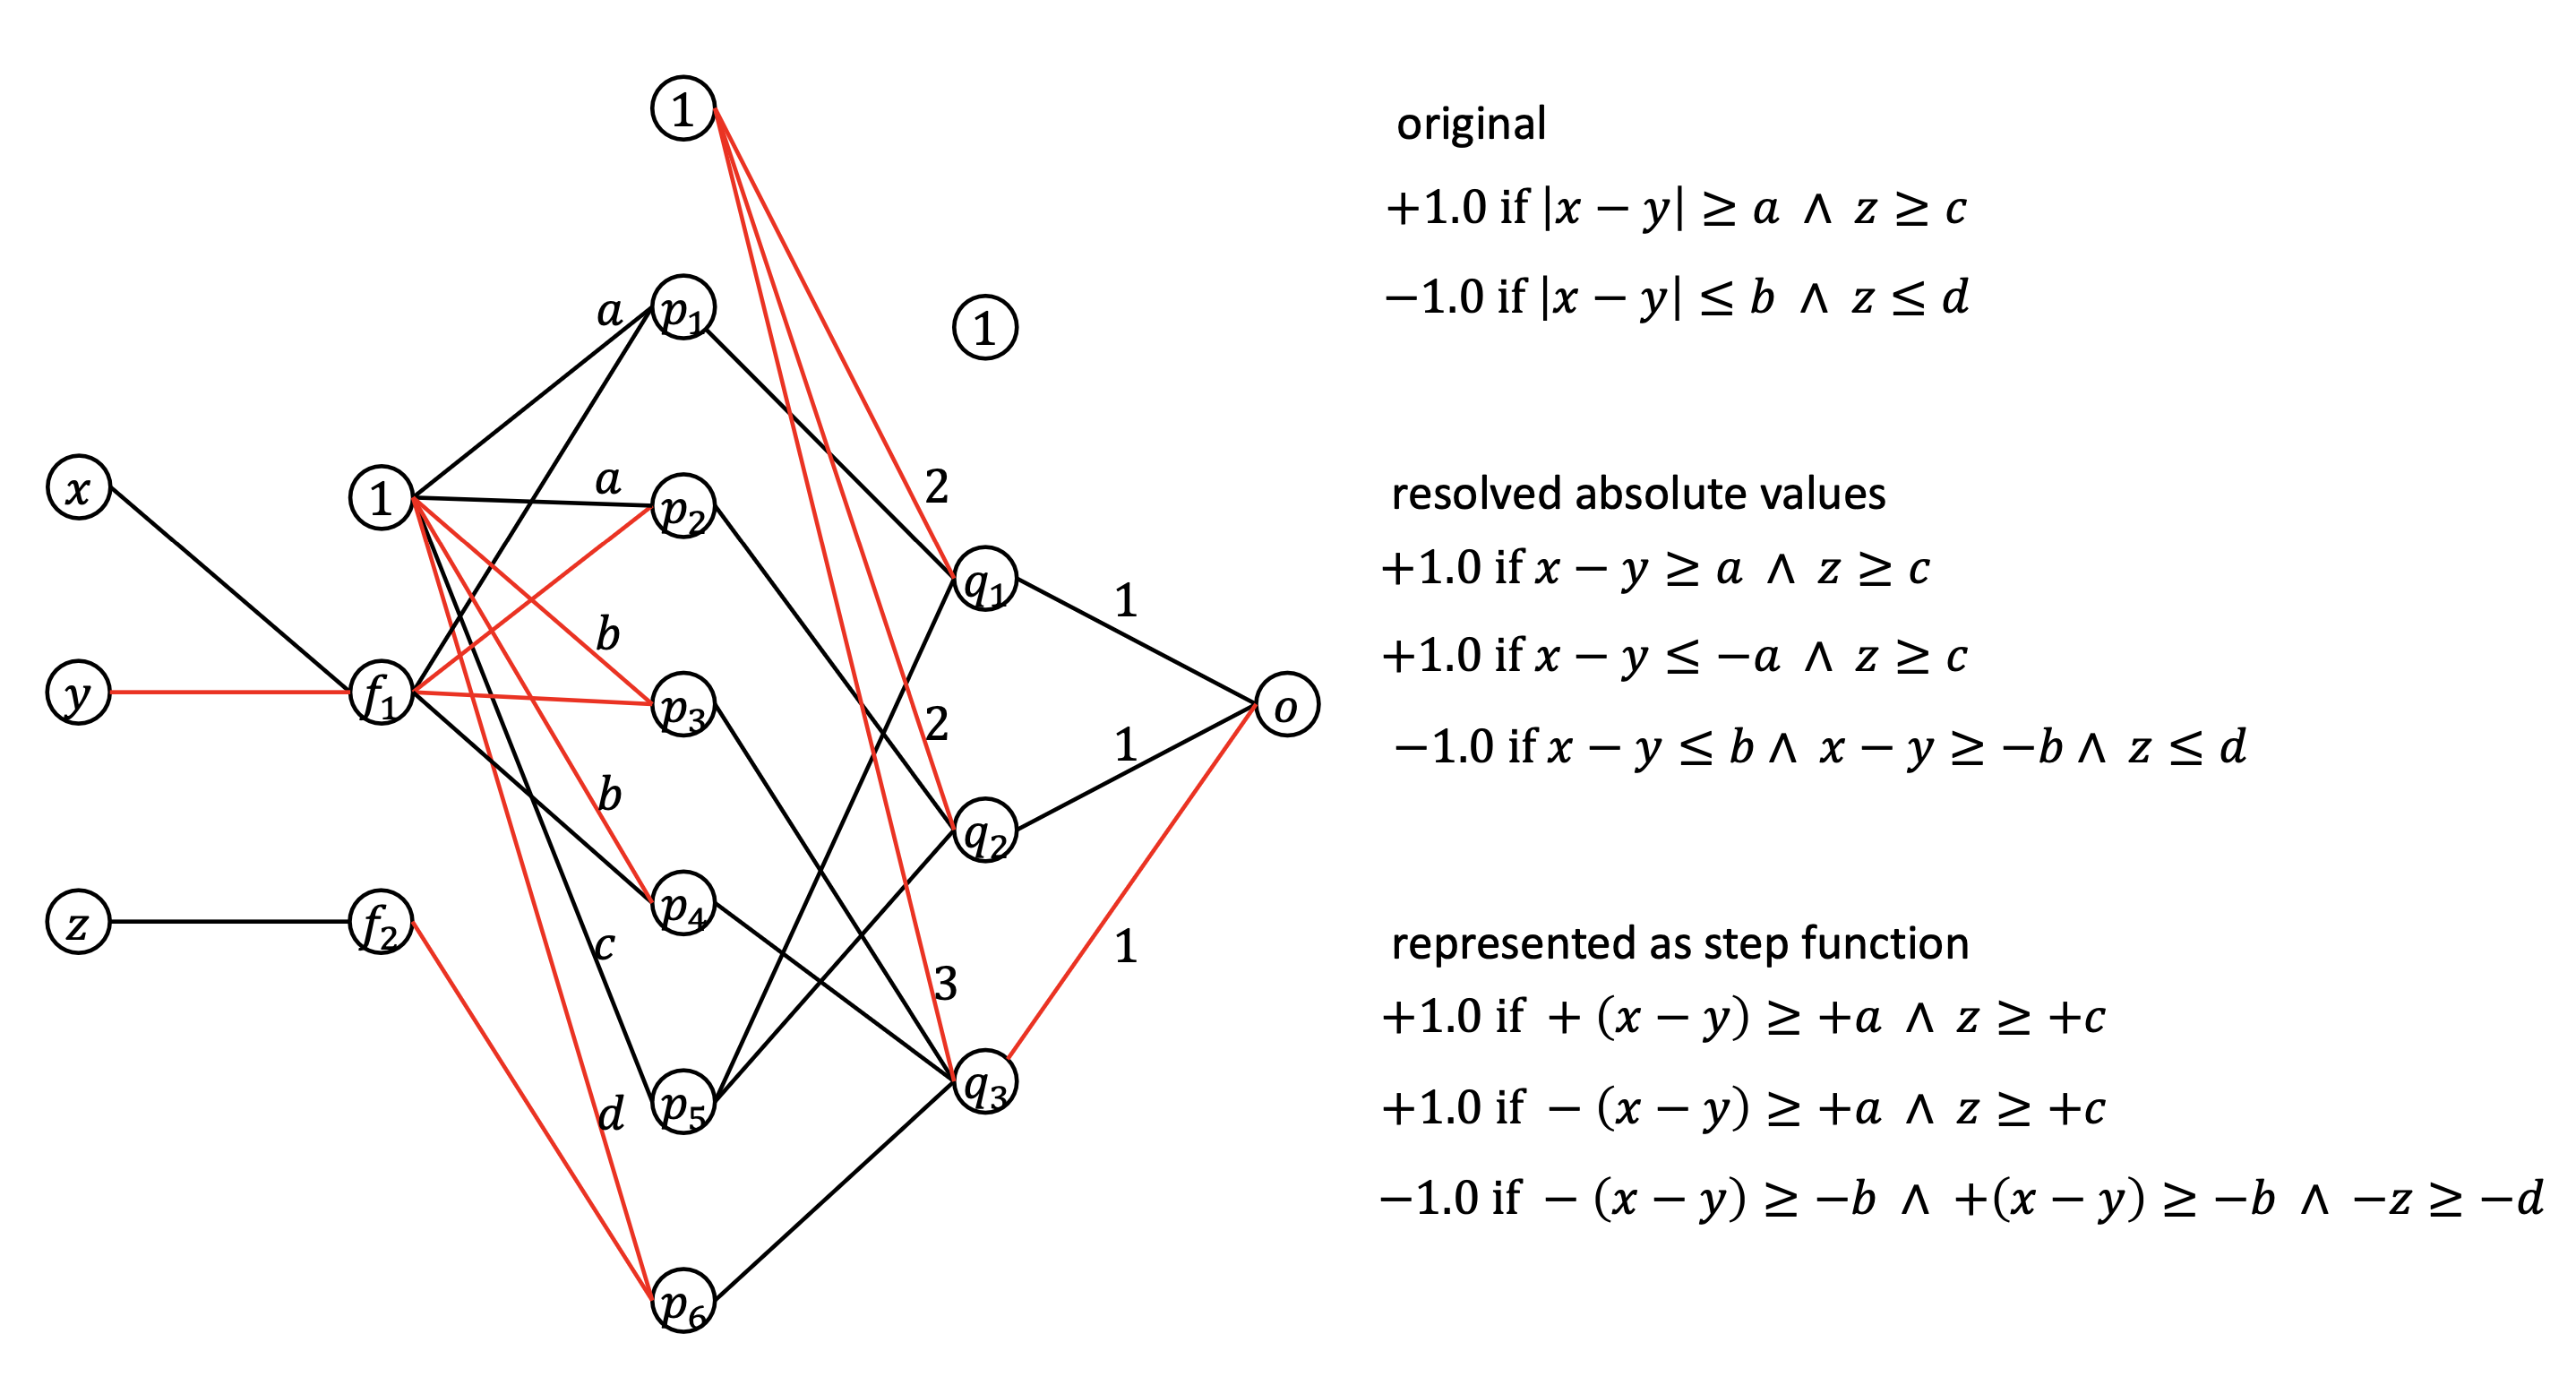

In [1115]:
from IPython import display
display.Image("OctetBinary.png")

# Loading Dataset and Transform to Tensor

In [1116]:
class OctetBinary(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.n_samples = X.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    

X = octet_selected[['sigma>0.91', 'sigma<-0.91', 'sigma<1.16', 'sigma>-1.16', 'rs>1.22','rs<1.27']].to_numpy()
y = octet_selected['RS_ZB'].to_numpy()
# y = octet_selected['Delta E'].to_numpy()

RNG = np.random.default_rng(seed=0)
train_ind = RNG.choice(len(X), size=int(len(X)*4), replace=True)
test_ind = np.setdiff1d(np.array(range(len(X))), train_ind)
X_train, X_test, y_train, y_test = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
    
dataset = OctetBinary(X_train, y_train)
dataloader = DataLoader(dataset=dataset, batch_size=int(1*len(X)), shuffle=True)

# Creating the NN Model

In [1117]:
class StepActivation(nn.Module):
    def forward(self, x):
        return torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))

class BinaryRounding(nn.Module):
    def forward(self, x):
        return torch.where(x >= 0.5, torch.tensor(1.0), torch.tensor(0.0))

class SigmoidMinusOneActivation(torch.nn.Module):
    def forward(self, x):
        return torch.sigmoid(x) - 1


class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bias=False):
        super(RegressionModel, self).__init__()
        self.bias = bias
        self.hidden = nn.Linear(input_size, hidden_size, bias=self.bias)
        # self.hidden = nn.Sequential(
        #     nn.Linear(input_size, hidden_size, bias=self.bias),
        #     nn.Sigmoid()
        # )
        self.output = nn.Linear(hidden_size, output_size, bias=False)

        # # Ground truth weights
        # if idealmodel:
        #     with torch.no_grad():
        #         hidden_weights = torch.tensor([[1,0,0,0,1,0],[0,1,0,0,1,0],[0,0,1,1,0,1]], dtype=torch.float32)
        #         self.hidden[0].weight.data = hidden_weights.clone()
        #         sum_of_weights_hidden = -self.hidden[0].weight.sum(dim=1)
        #         self.hidden[0].bias.data = sum_of_weights_hidden.clone()

        #         output_weights = torch.tensor([[1,1,-1]], dtype=torch.float32)
        #         self.output.weight.data = output_weights.clone()

        
    def forward(self, x):
        x = x - 1
        x = self.hidden(x)
        # x = torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))
        x = torch.sigmoid(10*x)
        x = self.output(x)
        # x = torch.tanh(10*x)
        return x

    def l1_loss(self):
        l1_loss = 0.0
        for param in self.parameters():
            l1_loss += torch.sum(torch.abs(param))
        return self.alpha * l1_loss
    
    def binary_loss(self):
        binary_loss = 0.0
        w_ = []
        for name, param in self.named_parameters():
            if name == 'hidden.0.weight':
                w_.append(param.reshape(-1,1))
            
        for v in w_:
            for v_i in v:
                if torch.abs(v_i) < torch.abs(v_i-1):
                    b = 0
                else:
                    b = 1
                binary_loss += torch.sum(torch.tensor(b))
        return binary_loss
    
    
    def round_parameters(self, hidden=True, output=False):
        for name, param in self.named_parameters():
            if name != 'output.weight' and hidden:
                param.data = torch.where(param.data >= 0.5, torch.tensor(1.0), torch.tensor(0.0)) #BinaryRounding.forward(param.data).clone().detach().requires_grad_(True)
            if name == 'output.weight' and output:
                param.data = torch.where(param.data >= 0.0, torch.tensor(1.0), torch.tensor(-1.0))

    def absolute_weights(self):
        for name, param in self.named_parameters():
            if name != 'output.weight':
                param.data = torch.abs(param.data)

    
    def predict(self, input):
        self.eval()
        input = torch.tensor(input, dtype=torch.float32)

        with torch.no_grad():
            output = self.forward(input)

        self.train()
        
        return output.numpy()
    

In [1118]:
# input_size = 6
# hidden_size = 3
# output_size = 1

# model = RegressionModel(input_size, hidden_size, output_size, bias=False)

# weights = []
# for name, param in model.named_parameters():
#     if name != 'output.weight':
#         param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
#     weights.append(param.detach().numpy())
#     print(name, param)

In [1119]:
# loss_criterion = nn.MSELoss()
# average_epoch_loss_list = []
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# alpha = 0
# num_epochs = 10000
# gradient_threshold = 1e-16
# epsilon = 1e-3
# for epoch in range(num_epochs):
#     epoch_loss = 0.0
#     for batch_x, batch_y in dataloader:
#         optimizer.zero_grad() 

#         # for name, param in model.named_parameters():
#         #     if name != 'output.weight': 
#         #         unrounded_weights = param.detach()
#         #         rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
#         #         param.data = rounded_weights
            
#         predictions = model(batch_x)  
#         mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
#         binary_loss = model.binary_loss()
#         total_loss = mse_loss + alpha*binary_loss 
#         total_loss.backward()  

#         # for name, param in model.named_parameters():
#         #     if name != 'output.weight': 
#         #         if param.grad is not None:
#         #             param.grad.data = torch.where(param.grad > 0, torch.tensor(1.0), torch.tensor(0.0))
#         #             param.data = unrounded_weights

#         optimizer.step() 
#         epoch_loss += total_loss.item()

#     average_epoch_loss = epoch_loss / len(dataloader)
#     average_epoch_loss_list.append(average_epoch_loss)

#     if epoch % 1000 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')



# plt.scatter(range(epoch+1), average_epoch_loss_list)
# plt.xlabel('epochs')
# plt.ylabel('(MSE + Regul.)/batch_size')

In [1120]:
# weights = []
# for name, param in model.named_parameters():
#     weights.append(param.detach().numpy())
#     print(name, param)

# model.round_parameters(hidden=True, output=True)
# for name, param in model.named_parameters():
#     # weights.append(param.detach().numpy())
#     print(name, param)

In [1121]:
# y_pred = model.predict(X_train)
# y_train = y_train.reshape(-1,1)
# print(f'MSE for unrounded parameters is: {(np.mean((y_train-y_pred)**2))}')

In [1122]:
# np.random.seed(19680801)
# # yaxis = [np.where(y_train>0.0, 1, -1),np.where(y_pred>0.0, 1, -1)]
# yaxis = [y_train,y_pred]
# axs_title = ['Ground Truth Data Points', 'Predicted Labels from Trained NN']
# fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# for col in range(2):
#     ax = axs[col]
#     pcm = ax.scatter(octet_selected['sigma'][train_ind],octet_selected['rs(A)'][train_ind], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-1, vmax=1)
#     ax.set_title(axs_title[col])

# # fig.suptitle('Prediction over Test Points')
# fig.colorbar(pcm)

# plt.scatter(range(len(y_pred)),y_train, label='TrainPoints')
# plt.scatter(range(len(y_pred)),y_pred, label='Preditions')
# plt.legend()

# Scenario 1: Rounding the Weights After Each Training
1. Initialise the Weights (Intentionally we choose random integers from -1 to 1 for hidden layer)
    
For each loop:

2. $y_{pred} = Model(X,W_b, \theta_t)$ (Froward Step)
3. $loss(y, y_{pred})$ 
4. $\nabla_{w_t} = \frac{\partial loss}{\partial W_t}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
5. $W_{t+1} = W_t + \eta \nabla_{w_t}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

6. $W = Binarize(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

hidden.weight Parameter containing:
tensor([[ 0., -1., -1.,  0., -1., -1.],
        [-1.,  0., -1.,  1.,  0.,  0.],
        [ 0., -1.,  0., -1., -1.,  0.]], requires_grad=True)
output.weight Parameter containing:
tensor([[0.0549, 0.1672, 0.5053]], requires_grad=True)
Epoch [1/10000] Loss: 1.5238
Epoch [1001/10000] Loss: 0.6685
Epoch [2001/10000] Loss: 0.1814
Epoch [3001/10000] Loss: 0.0130
Epoch [4001/10000] Loss: 0.0001
Epoch [5001/10000] Loss: 0.0000
Epoch [6001/10000] Loss: 0.0000
Epoch [7001/10000] Loss: 0.0000
Epoch [8001/10000] Loss: 0.0000
Epoch [9001/10000] Loss: 0.0000
hidden.weight Parameter containing:
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1., 0.]], requires_grad=True)
output.weight Parameter containing:
tensor([[-1., -1.,  1.]], requires_grad=True)
The MSE is 0.5038


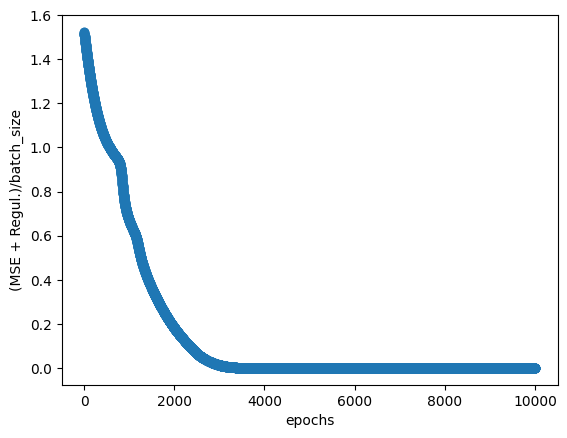

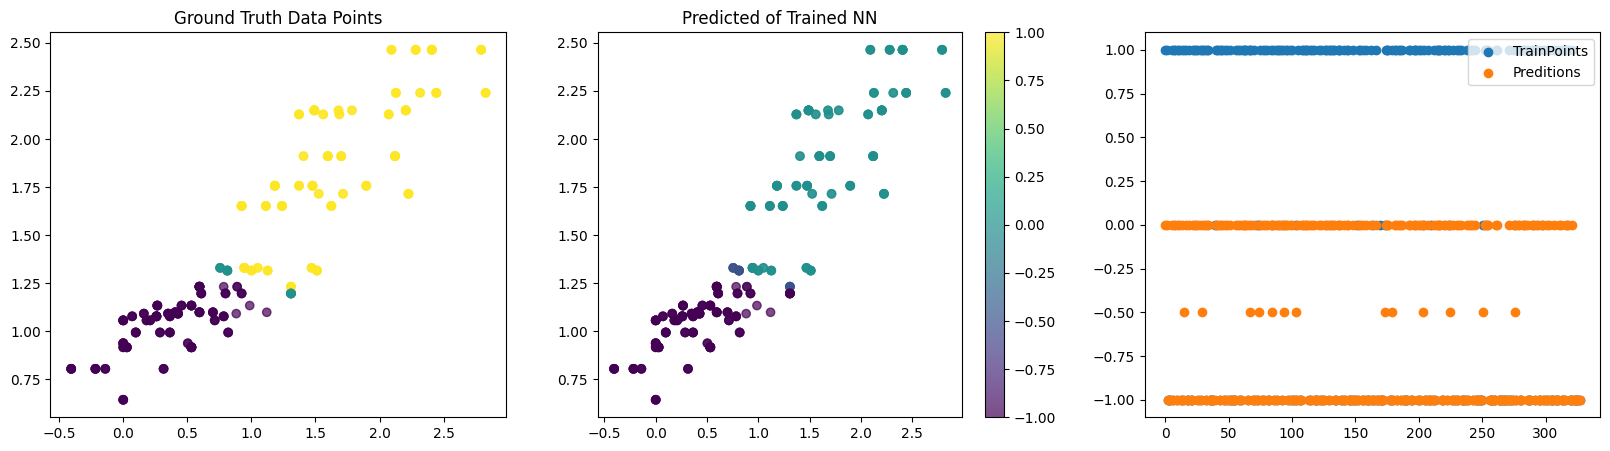

In [1123]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0
num_epochs = 10000
model_1 = RegressionModel(input_size, hidden_size, output_size, bias=False)
for name, param in model_1.named_parameters():
    if name != 'output.weight':
        param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
    #     param.data = torch.tensor([[ 0., -1.,  0.,  1., -1.,  0.], [ 1.,  1.,  1., -1., -1.,  0.], [ 0., -1., -1., -1., -1.,  0.]], dtype=torch.float32)
    # if name == 'output.weight':
    #     param.data = torch.tensor([[0.3067, 0.4690, 0.4114]], dtype=torch.float32)
    print(name, param)

optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0001)
average_epoch_loss_list_1 = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad() 
        predictions = model_1(batch_x)  
        mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
        binary_loss = model_1.binary_loss()
        total_loss = mse_loss + alpha*binary_loss 
        total_loss.backward()  
        optimizer.step() 
        epoch_loss += total_loss.item()

    average_epoch_loss = epoch_loss / len(dataloader)
    average_epoch_loss_list_1.append(average_epoch_loss)
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')

plt.scatter(range(epoch+1), average_epoch_loss_list_1)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')

model_1.round_parameters(hidden=True, output=True)
for name, param in model_1.named_parameters():
    print(name, param)
y_pred_1 = model_1.predict(X_train)
y_train = y_train.reshape(-1,1)
mse_1 = np.mean((y_train-y_pred_1)**2)
print(f'The MSE is {mse_1:.4f}')

np.random.seed(19680801)
# yaxis = [np.where(y_train>0.0, 1, -1),np.where(y_pred>0.0, 1, -1)]
yaxis = [y_train,y_pred_1]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'][train_ind],octet_selected['rs(A)'][train_ind], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

fig.colorbar(pcm)
axs[2].scatter(range(len(y_pred_1)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_pred_1)),y_pred_1, label='Preditions')
axs[2].legend()

# Scenario 2: Rounding the Proposition Layer Weights in Each Training Loop before Forward Step
1. Initialise the Weights (Intentionally we choose random integers from -1 to 1 for hidden layer)

For each epoch:

2. $W_b = Binarize(W_t)$
3. $y_{pred} = Model(X,W_b, \theta_t)$ (Froward Step)
4. $loss(y, y_{pred})$ 
5. $\nabla_{w_b} = \frac{\partial loss}{\partial W_b}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
6. $W_{b+1} = W_b + \eta \nabla_{w_b}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

7. $W = Binarize(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

hidden.weight Parameter containing:
tensor([[-1.,  0.,  0.,  0.,  1., -1.],
        [ 0., -1.,  0.,  1.,  1., -1.],
        [-1., -1.,  0.,  1., -1., -1.]], requires_grad=True)
output.weight Parameter containing:
tensor([[-0.4675, -0.3831,  0.5689]], requires_grad=True)
Epoch [1/10000] Loss: 1.3750
Epoch [1001/10000] Loss: 1.0091
Epoch [2001/10000] Loss: 0.7199
Epoch [3001/10000] Loss: 0.4997
Epoch [4001/10000] Loss: 0.3454
Epoch [5001/10000] Loss: 0.2512
Epoch [6001/10000] Loss: 0.2042
Epoch [7001/10000] Loss: 0.1877
Epoch [8001/10000] Loss: 0.1850
Epoch [9001/10000] Loss: 0.1848
hidden.weight Parameter containing:
tensor([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0., 0.]], requires_grad=True)
output.weight Parameter containing:
tensor([[ 1.,  1., -1.]], requires_grad=True)
The MSE is 0.3293


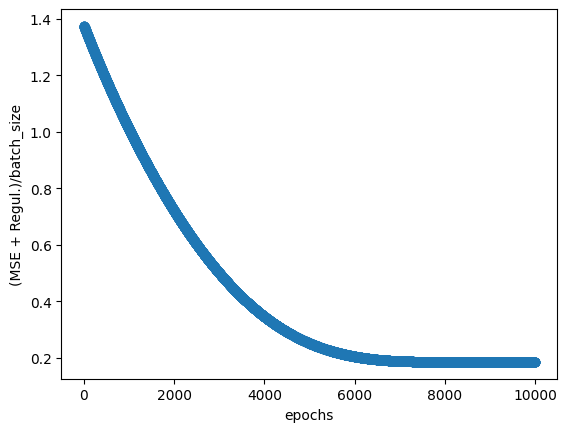

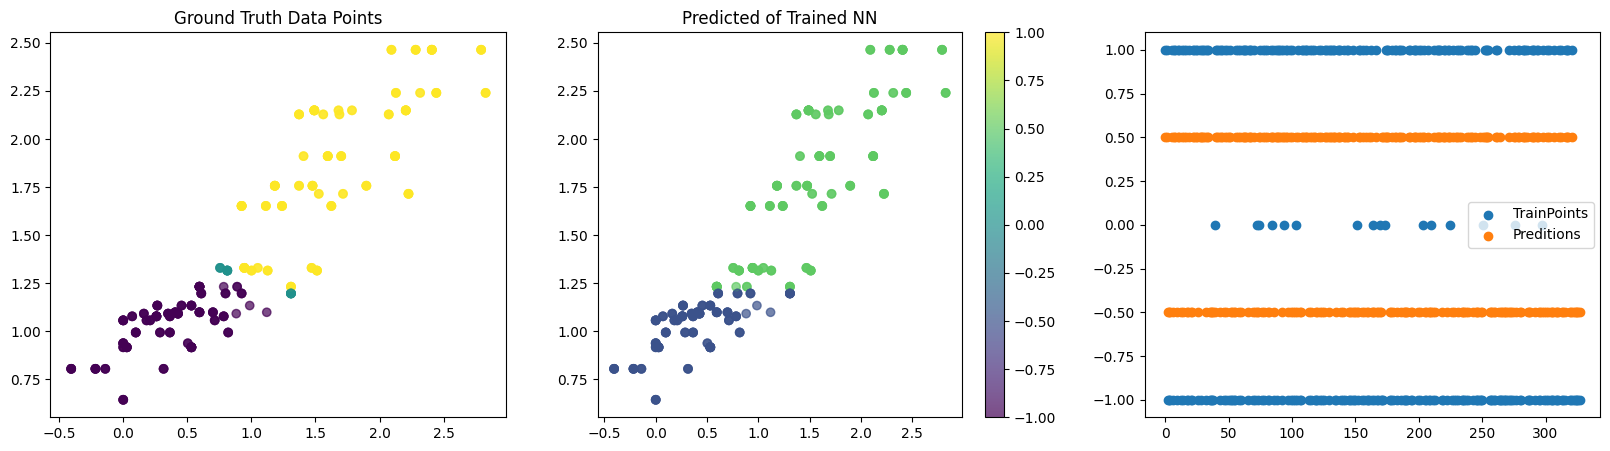

In [1124]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0
num_epochs = 10000
model_2 = RegressionModel(input_size, hidden_size, output_size, bias=False)
for name, param in model_2.named_parameters():
    if name != 'output.weight':
        param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
    #     param.data = torch.tensor([[ 0., -1.,  0.,  1., -1.,  0.], [ 1.,  1.,  1., -1., -1.,  0.], [ 0., -1., -1., -1., -1.,  0.]], dtype=torch.float32)
    # if name == 'output.weight':
    #     param.data = torch.tensor([[0.3067, 0.4690, 0.4114]], dtype=torch.float32)
    print(name, param)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0001)
average_epoch_loss_list_2 = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad() 

        for name, param in model_2.named_parameters():
            if name != 'output.weight': 
                rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
                param.data = rounded_weights
                
        predictions = model_2(batch_x)  
        mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
        binary_loss = model_2.binary_loss()
        total_loss = mse_loss + alpha*binary_loss 
        total_loss.backward()  
        optimizer.step() 
        epoch_loss += total_loss.item()

    average_epoch_loss = epoch_loss / len(dataloader)
    average_epoch_loss_list_2.append(average_epoch_loss)
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')

plt.scatter(range(epoch+1), average_epoch_loss_list_2)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')

model_2.round_parameters(hidden=True, output=True)
for name, param in model_2.named_parameters():
    print(name, param)
y_pred_2 = model_2.predict(X_train)
y_train = y_train.reshape(-1,1)
mse_2 = np.mean((y_train-y_pred_2)**2)
print(f'The MSE is {mse_2:.4f}')

np.random.seed(19680801)
# yaxis = [np.where(y_train>0.0, 1, -1),np.where(y_pred>0.0, 1, -1)]
yaxis = [y_train,y_pred_2]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'][train_ind],octet_selected['rs(A)'][train_ind], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

fig.colorbar(pcm)
axs[2].scatter(range(len(y_pred_2)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_pred_2)),y_pred_2, label='Preditions')
axs[2].legend()

# Scenario 3: Rounding the Proposition Layer Weights before Forward Step and Update the nonbinarized Weight
1- Initialise the Weights (Intentionally we choose random integers from -1 to 1 for hidden layer)

For each epoch:

2. Keeping $W_t, \theta_t$ 
3. $W_b = Binarize(W_t)$ 
4. $y_{pred} = Model(X,W_b, \theta)$ (Froward Step)
5. $loss(y, y_{pred})$ 
6. $\nabla_{w_b} = \frac{\partial loss}{\partial W_b}$ and $\nabla_{\theta_t} = \frac{\partial loss}{\partial \theta_t}$ (Backward Step)
7. $W_{t+1} = W_t + \eta \nabla_{w_b}$ and $\theta_{t+1} = \theta_t + \eta \nabla_{\theta_t}$ (Update Step)

After converging

8. $W = Binarize(W_{\tau})$ and $\theta = Sign(\theta_{\tau})$ 

hidden.weight Parameter containing:
tensor([[ 1.,  1., -1.,  0.,  0.,  1.],
        [-1.,  0.,  0., -1., -1.,  0.],
        [ 0.,  1., -1., -1.,  0.,  0.]], requires_grad=True)
output.weight Parameter containing:
tensor([[ 0.2236, -0.2297, -0.2548]], requires_grad=True)
Epoch [1/10000] Loss: 0.9574
Epoch [1001/10000] Loss: 0.9551
Epoch [2001/10000] Loss: 0.9535
Epoch [3001/10000] Loss: 0.8507
Epoch [4001/10000] Loss: 0.7871
Epoch [5001/10000] Loss: 0.7355
Epoch [6001/10000] Loss: 0.6937
Epoch [7001/10000] Loss: 0.6439
Epoch [8001/10000] Loss: 0.6112
Epoch [9001/10000] Loss: 0.5843
hidden.weight Parameter containing:
tensor([[1., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.]], requires_grad=True)
output.weight Parameter containing:
tensor([[ 1., -1., -1.]], requires_grad=True)
The MSE is 0.5831


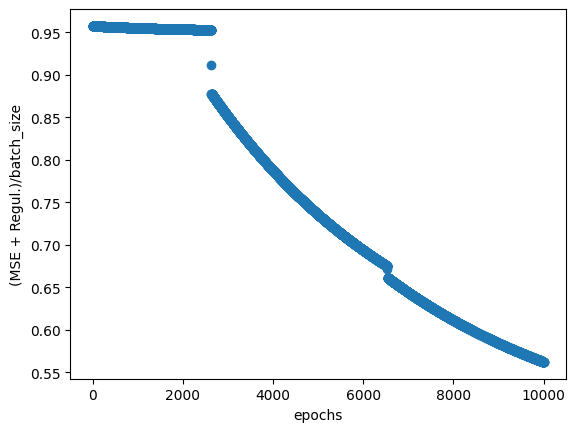

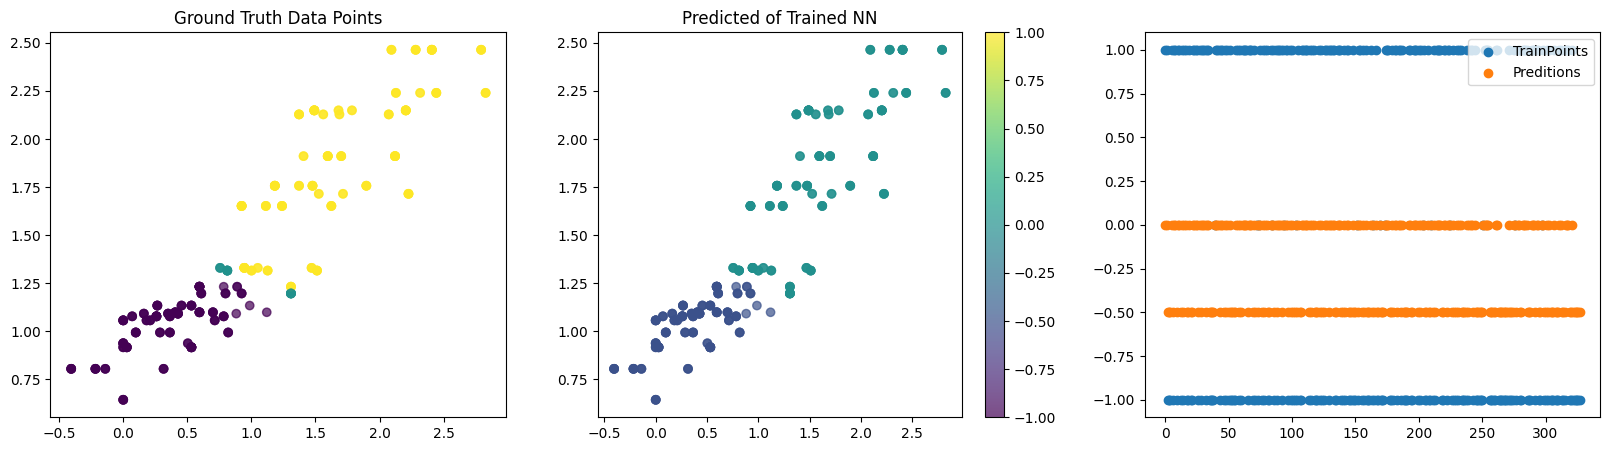

In [1240]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0
num_epochs = 10000
model_3 = RegressionModel(input_size, hidden_size, output_size, bias=False)
for name, param in model_3.named_parameters():
    if name != 'output.weight':
        param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)
    #     param.data = torch.tensor([[ 0., -1.,  0.,  1., -1.,  0.], [ 1.,  1.,  1., -1., -1.,  0.], [ 0., -1., -1., -1., -1.,  0.]], dtype=torch.float32)
    # if name == 'output.weight':
    #     param.data = torch.tensor([[0.3067, 0.4690, 0.4114]], dtype=torch.float32)
    print(name, param)
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.0001)
average_epoch_loss_list_3 = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad() 

        for name, param in model_3.named_parameters():
            if name != 'output.weight':
                unrounded_weights = param.detach()
                rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
                param.data = rounded_weights
                
        predictions = model_3(batch_x)  
        mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
        binary_loss = model_3.binary_loss()
        total_loss = mse_loss + alpha*binary_loss 
        total_loss.backward()  

        for name, param in model_3.named_parameters():
            if name != 'output.weight': 
                if param.grad is not None:
                    param.data = unrounded_weights

        optimizer.step() 
        epoch_loss += total_loss.item()

    average_epoch_loss = epoch_loss / len(dataloader)
    average_epoch_loss_list_3.append(average_epoch_loss)
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')

plt.scatter(range(epoch+1), average_epoch_loss_list_3)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')

model_3.round_parameters(hidden=True, output=True)
for name, param in model_3.named_parameters():
    print(name, param)
y_pred_3 = model_3.predict(X_train)
y_train = y_train.reshape(-1,1)
mse_3 = np.mean((y_train-y_pred_3)**2)
print(f'The MSE is {mse_3:.4f}')

np.random.seed(19680801)
# yaxis = [np.where(y_train>0.0, 1, -1),np.where(y_pred>0.0, 1, -1)]
yaxis = [y_train,y_pred_3]
axs_title = ['Ground Truth Data Points', 'Predicted of Trained NN']
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for col in range(2):
    ax = axs[col]
    pcm = ax.scatter(octet_selected['sigma'][train_ind],octet_selected['rs(A)'][train_ind], c=yaxis[col], cmap='viridis',  alpha=0.7, vmin=-1, vmax=1)
    ax.set_title(axs_title[col])

fig.colorbar(pcm)
axs[2].scatter(range(len(y_train)),y_train, label='TrainPoints')
axs[2].scatter(range(len(y_train)),y_pred_3, label='Preditions')
axs[2].legend()

In [1215]:
input_size = 6
hidden_size = 3
output_size = 1
loss_criterion = nn.MSELoss()
alpha = 0
num_epochs = 10000
MSElist = []
w_per_rep = []
for reps in range(100):
    model_3 = RegressionModel(input_size, hidden_size, output_size, bias=False)
    for name, param in model_3.named_parameters():
        if name != 'output.weight':
            param.data = torch.randint(-1, 2, size=param.size(), dtype=torch.float32)

    optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
    average_epoch_loss_list_3 = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad() 

            for name, param in model_3.named_parameters():
                if name != 'output.weight':
                    unrounded_weights = param.detach()
                    rounded_weights = torch.where(param >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
                    param.data = rounded_weights
                    
            predictions = model_3(batch_x)  
            mse_loss = loss_criterion(predictions, batch_y.view(-1,1)) 
            binary_loss = model_3.binary_loss()
            total_loss = mse_loss + alpha*binary_loss 
            total_loss.backward()  

            for name, param in model_3.named_parameters():
                if name != 'output.weight': 
                    if param.grad is not None:
                        param.data = unrounded_weights

            optimizer.step() 
            epoch_loss += total_loss.item()

        average_epoch_loss = epoch_loss / len(dataloader)
        average_epoch_loss_list_3.append(average_epoch_loss)
        # if epoch % 1000 == 0:
        #     print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')

    model_3.round_parameters(hidden=True, output=True)
    w_ = []
    for name, param in model_3.named_parameters():
        w_.append(param.detach().numpy())
    w_per_rep.append(w_)
    y_pred_3 = model_3.predict(X_train)
    y_train = y_train.reshape(-1,1)
    mse_3 = np.mean((y_train-y_pred_3)**2)
    MSElist.append(mse_3)
    print(f'Reps: {reps}')

Reps: 0
Reps: 1
Reps: 2
Reps: 3
Reps: 4
Reps: 5
Reps: 6
Reps: 7
Reps: 8
Reps: 9
Reps: 10
Reps: 11
Reps: 12
Reps: 13
Reps: 14
Reps: 15
Reps: 16
Reps: 17
Reps: 18
Reps: 19
Reps: 20
Reps: 21
Reps: 22
Reps: 23
Reps: 24
Reps: 25
Reps: 26
Reps: 27
Reps: 28
Reps: 29
Reps: 30
Reps: 31
Reps: 32
Reps: 33
Reps: 34
Reps: 35
Reps: 36
Reps: 37
Reps: 38
Reps: 39
Reps: 40
Reps: 41
Reps: 42
Reps: 43
Reps: 44
Reps: 45
Reps: 46
Reps: 47
Reps: 48
Reps: 49
Reps: 50
Reps: 51
Reps: 52
Reps: 53
Reps: 54
Reps: 55
Reps: 56
Reps: 57
Reps: 58
Reps: 59
Reps: 60
Reps: 61
Reps: 62
Reps: 63
Reps: 64
Reps: 65
Reps: 66
Reps: 67
Reps: 68
Reps: 69
Reps: 70
Reps: 71
Reps: 72
Reps: 73
Reps: 74
Reps: 75
Reps: 76
Reps: 77
Reps: 78
Reps: 79
Reps: 80
Reps: 81
Reps: 82
Reps: 83
Reps: 84
Reps: 85
Reps: 86
Reps: 87
Reps: 88
Reps: 89
Reps: 90
Reps: 91
Reps: 92
Reps: 93
Reps: 94
Reps: 95
Reps: 96
Reps: 97
Reps: 98
Reps: 99


In [1226]:
ws = []
tetas = []

for row, w in enumerate(w_per_rep):
    ws.append(w[0])
    tetas.append(w[1])

ws = np.array(ws)
tetas = np.array(tetas)
# np.unique(tetas, axis=0, return_counts=True, return_index=True)
a,indices,counts = np.unique(ws, axis=0, return_counts=True, return_index=True)
ws[indices[np.argmax(counts)]]
tetas[np.argmax(counts)]

array([[ 1.,  1., -1.]], dtype=float32)

In [1236]:
sorted_mse = np.sort(MSElist)

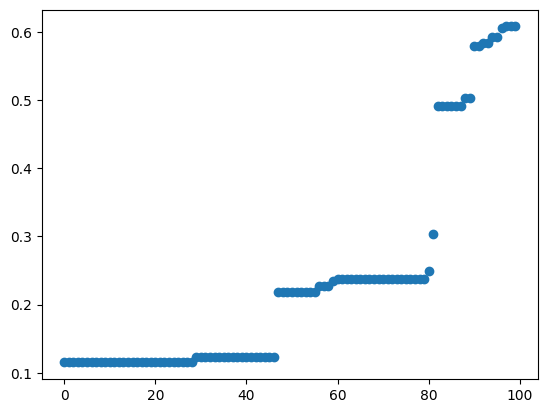

In [1237]:
plt.scatter(range(len(sorted_mse)),sorted_mse)